# **XAI4Spectra**

# **Loading data**

In [192]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import kennard_stone as ks

# loading a soil spectral dataset based on X-ray fluorescence (XRF)
#data_complete = pd.read_csv('https://raw.githubusercontent.com/joseviniciusr/XAI4Spectra/main/XRFspectra.csv', sep=';') # Toledo 2022 dataset
data_complete = pd.read_csv('XRFspectra.csv', sep=';') # local copy of Toledo 2022 dataset
data = data_complete.loc[:, '1':'15']
data.insert(0, 'exCa', data_complete['exCa'])  # inserting the target variable (e.g., exCa (exchangeable calcium))

## **PLS- (R or DA) modeling**

In [193]:
def vip_scores(pls_model):
    """
    Calculate VIP (Variable Importance in Projection) scores for a fitted PLS model.
    Parameters
    ----------
    - **pls_model** : fitted PLS model object from sklearn.cross_decomposition.PLSRegression
        The PLS model for which to calculate VIP scores.
    Returns
    -------
    - vip_scores : ndarray, shape (n_features,)
        VIP scores for each feature in the model.
    """
    import numpy as np

    t = pls_model.x_scores_ # X scores 
    w = pls_model.x_weights_ # X weights
    p = pls_model.y_loadings_ # Y loadings
    features, _ = w.shape # number of features
    vip = np.zeros(shape=(features,)) # initializing VIP scores array
    inner_sum = np.diag(t.T @ t @ p.T @ p) # inner sum calculation
    SS_total = np.sum(inner_sum) # total sum of squares
    vip = np.sqrt(features*(w**2 @ inner_sum)/ SS_total) # VIP calculation
    return pd.DataFrame(vip)

def explained_variance_from_scores(X, T, P, Q=None, Y=None):
    """
    Calculate percent variance explained (based on PCTVAR Matlab function) for X and Y
    by using the scores T and loadings P (and optionally Q for Y).
    Parameters
    ----------
    - **X** : array-like, shape (n_samples, n_features)
        X matrix used in PLS.
    - **T** : array-like, shape (n_samples, n_components)
        Scores matrix from PLS.
    - **P** : array-like, shape (n_features, n_components)
        Loadings matrix for X from PLS.
    - **Q** : array-like, shape (n_targets, n_components), optional
        Loadings matrix for Y from PLS. Required if Yc is provided.
    - **Y** : array-like, shape (n_samples, n_targets), optional
       Y matrix used in PLS.
    Returns
    -------
    - result : dict with keys:
        - **'varX_cumulative'** : ndarray shape (n_components,)
            Percent cumulative variance of X explained by 1..j components.
        - **'varX_per_component'** : ndarray shape (n_components,)
            Percent variance of X explained per component.
        - **'varY_cumulative'** : ndarray shape (n_components,), or None
            Percent cumulative variance of Y explained by 1..j components (if Yc and Q provided).
        - **'varY_per_component'** : ndarray shape (n_components,), or None
            Percent variance of Y explained per component (if Yc and Q provided).
    """
    import numpy as np
    X = np.asarray(X, dtype=float) # X preprocessed data
    T = np.asarray(T, dtype=float) # scores
    P = np.asarray(P, dtype=float) # loadings for X

    n_comp = T.shape[1]
    TSS_X = np.sum(X ** 2) # total sum of squares of X
    if TSS_X == 0: # avoid division by zero
        raise ValueError("TSS_X == 0 (X does not have variability).")

    pctvarX_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for X

    for j in range(1, n_comp + 1): # loop over components
        Xhat_j = T[:, :j] @ P[:, :j].T # reconstructed X using j components
        SS_Xhat_j = np.sum(Xhat_j ** 2) # sum of squares of reconstructed X
        pctvarX_cum[j-1] = 100.0 * SS_Xhat_j / TSS_X # percent variance explained cumulativa
    
    # incremental (per component)
    pctvarX_per = np.empty_like(pctvarX_cum) # incremental percent variance for X
    pctvarX_per[0] = pctvarX_cum[0] # first component
    pctvarX_per[1:] = pctvarX_cum[1:] - pctvarX_cum[:-1] # rest

    # Y (if provided)
    pctvarY_cum = None # cumulative percent variance for Y
    pctvarY_per = None # incremental percent variance for Y
    if Q is not None and Y is not None: # if Y loadings and Y centered provided
        Q = np.asarray(Q, dtype=float) # loadings for Y
        Y = np.asarray(Y, dtype=float) # centered (and possibly scaled) Y
        TSS_Y = np.sum(Y ** 2) # total sum of squares of Y
        if TSS_Y == 0: # avoid division by zero
            pctvarY_cum = np.zeros(n_comp, dtype=float) # all zeros if Y has no variance
            pctvarY_per = np.zeros(n_comp, dtype=float) # all zeros
        else:
            pctvarY_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for Y
            for j in range(1, n_comp + 1): # loop over components
                Yhat_j = T[:, :j] @ Q[:, :j].T # reconstructed Y using j components
                SS_Yhat_j = np.sum(Yhat_j ** 2) # sum of squares of reconstructed Y
                pctvarY_cum[j-1] = 100.0 * SS_Yhat_j / TSS_Y # percent variance explained cumulativa
            pctvarY_per = np.empty_like(pctvarY_cum) # incremental percent variance for Y
            pctvarY_per[0] = pctvarY_cum[0] # first component
            pctvarY_per[1:] = pctvarY_cum[1:] - pctvarY_cum[:-1] # rest

        return {
            'varX_cumulative': pctvarX_cum[-1],
            'varX_per_component': pctvarX_per[-1],
            'varY_cumulative': pctvarY_cum[-1],
            'varY_per_component': pctvarY_per[-1]
            }         


def pls_optimized(Xcal, ycal, LVmax, Xpred=None, ypred=None, aim='regression', cv=10):
    """
    ## PLS optimized
    Function to fit a PLS regression or PLS-DA model with optimization of latent variables (LVs)
    using cross-validation. It calculates various performance metrics for calibration, cross-validation,
    and prediction (if provided) datasets
    **Parameters**:
    - **Xcal** : pd.DataFrame
        Calibration dataset features.
    - **ycal** : pd.Series or np.ndarray
        Calibration dataset target variable (regression) or binary class labels (classification).
    - **LVmax** : int
        Maximum number of latent variables to consider.
    - **Xpred** : pd.DataFrame, optional
        Prediction dataset features. Default is None.
    - **ypred** : pd.Series or np.ndarray, optional
        Prediction dataset target variable (regression) or binary class labels (classification). Default is None.
    - **aim** : str, optional
        Type of analysis: 'regression' for PLS regression or 'classification' for PLS-DA. Default is 'regression'.
    - **cv** : int, optional
        Number of cross-validation folds. Default is 10
        
    **Returns**:
    - **df_results** : pd.DataFrame
        DataFrame containing performance metrics for each number of latent variables.
    - **calres** : pd.DataFrame
        DataFrame containing predicted values for the calibration dataset.
    - **predres** : pd.DataFrame
        DataFrame containing predicted values for the prediction dataset (if provided).
    """

    import numpy as np
    import pandas as pd

    if aim == 'regression': # regression (PLSR)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import mean_squared_error, r2_score
        from scipy.stats import iqr

        results = [] # list to store results for each LV
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsr = PLSRegression(n_components=n_comp, scale=False)
            plsr.fit(Xcal, ycal)
            y_cal = plsr.predict(Xcal).flatten()
            calres[f'LV_{n_comp}'] = y_cal

            y_cv = cross_val_predict(plsr, Xcal, ycal, cv=cv) # cross-validated predictions
            y_cv = np.array(y_cv).flatten()

            R2_cal = r2_score(ycal, y_cal) # determination coefficient
            r2_cal = np.corrcoef(ycal, y_cal)[0, 1] ** 2 # correlation coefficient squared
            rmse_cal = np.sqrt(mean_squared_error(ycal, y_cal))
            R2_cv = r2_score(ycal, y_cv)
            r2_cv = np.corrcoef(ycal, y_cv)[0, 1] ** 2
            rmsecv = np.sqrt(mean_squared_error(ycal, y_cv))
            rpd_cv = ycal.std() / rmsecv if rmsecv != 0 else np.nan
            rpiq_cv = iqr(ycal, rng=(25, 75)) / rmsecv if rmsecv != 0 else np.nan
            bias_cv = np.sum(ycal - y_cv) / ycal.shape[0]
            SDV_cv = (ycal - y_cv) - bias_cv
            SDV_cv = np.sqrt(np.sum(SDV_cv * SDV_cv) / (ycal.shape[0] - 1)) if ycal.shape[0] > 1 else np.nan
            tbias_cv = abs(bias_cv) * (np.sqrt(ycal.shape[0]) / SDV_cv) if SDV_cv not in (0, np.nan) else np.nan
            
            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsr.x_scores_, plsr.x_loadings_,
                                               Q=plsr.y_loadings_, Y=ycal) # explained variance
            
            # vip scores
            vip = vip_scores(plsr).T
            vip.columns = plsr.feature_names_in_ # setting feature names

            if Xpred is not None and ypred is not None: # prediction set
                y_pred = plsr.predict(Xpred).flatten()
                predres[f'LV_{n_comp}'] = y_pred

                R2_pred = r2_score(ypred, y_pred) # determination coefficient
                r2_pred = np.corrcoef(ypred, y_pred)[0, 1] ** 2 # correlation coefficient squared
                rmsep = np.sqrt(mean_squared_error(ypred, y_pred))
                rpd_pred = ypred.std() / rmsep if rmsep != 0 else np.nan
                rpiq_pred = iqr(ypred, rng=(25, 75)) / rmsep if rmsep != 0 else np.nan
                bias_pred = np.sum(ypred - y_pred) / ypred.shape[0]
                SDV_pred = (ypred - y_pred) - bias_pred
                SDV_pred = np.sqrt(np.sum(SDV_pred * SDV_pred) / (ypred.shape[0] - 1)) if ypred.shape[0] > 1 else np.nan
                tbias_pred = abs(bias_pred) * (np.sqrt(ypred.shape[0]) / SDV_pred) if SDV_pred not in (0, np.nan) else np.nan
            else:
                r2_pred = rmsep = rpd_pred = rpiq_pred = bias_pred = tbias_pred = None

            results.append({
                'LVs': n_comp,
                'R2_Cal': R2_cal,
                'r2_Cal': r2_cal,
                'RMSEC': rmse_cal,
                'R2_CV': R2_cv,
                'r2_Cv': r2_cv,
                'RMSECV': rmsecv,
                'RPD_CV': rpd_cv,
                'RPIQ_CV': rpiq_cv,
                'Bias_CV': bias_cv,
                'tbias_CV': tbias_cv,
                'R2_Pred': R2_pred,
                'r2_Pred': r2_pred,
                'RMSEP': rmsep,
                'RPD_Pred': rpd_pred,
                'RPIQ_Pred': rpiq_pred,
                'Bias_Pred': bias_pred,
                'tbias_Pred': tbias_pred,
                'X_Cum_Exp_Var' : exp_var['varX_cumulative'],
                'Y_Cum_Exp_Var' : exp_var['varY_cumulative'],
                'X_Ind_Exp_Var' : exp_var['varX_per_component'],
                'Y_Ind_Exp_Var' : exp_var['varY_per_component']
            })

        model = plsr  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    elif aim == 'classification': # classification (PLS-DA)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import accuracy_score, confusion_matrix

        results = []
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        # ensure binary classes
        ycal_series = pd.Series(ycal).reset_index(drop=True) # ensure it's a Series
        unique_labels = ycal_series.unique() # unique class labels
        if len(unique_labels) != 2: # check for binary classification
            raise ValueError(f"PLS-DA (this function) expects 2 classes (binary). Found: {unique_labels}")

        label_to_num = {lab: idx for idx, lab in enumerate(unique_labels)} # mapping labels to 0 and 1
        num_to_label = {idx: lab for lab, idx in label_to_num.items()} # reverse mapping for predictions
       
        # prepare ycal numeric
        ycal_numeric = np.array([label_to_num[i] for i in ycal]) 

        # prepare ypred numeric if provided
        ypred_numeric = None
        if ypred is not None:
            ypred_numeric = np.array([label_to_num[i] for i in ypred])

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsda = PLSRegression(n_components=n_comp, scale=False)
            plsda.fit(Xcal, ycal_numeric)

            # calibration continuous predictions -> binarize
            y_cal_cont = plsda.predict(Xcal).flatten()
            y_cal_bin = (y_cal_cont >= 0.5).astype(int)
            y_cal_class = np.array([num_to_label[i] for i in y_cal_bin])
            calres[f'LV_{n_comp}'] = y_cal_class
            calres_numeric = pd.DataFrame(y_cal_cont, columns=[f'LV_{n_comp}']) # numeric calibration results

            # cross-validated continuous predictions -> binarize
            y_cv_cont = cross_val_predict(plsda, Xcal, ycal_numeric, cv=cv)
            y_cv_cont = np.array(y_cv_cont).flatten()
            y_cv_bin = (y_cv_cont >= 0.5).astype(int)

            # metrics
            acc_cal = accuracy_score(ycal_numeric, y_cal_bin)
            cm_cal = confusion_matrix(ycal_numeric, y_cal_bin)
            # safe unpack for binary confusion matrix
            if cm_cal.size == 4:
                tn, fp, fn, tp = cm_cal.ravel()
            else:
                tn = fp = fn = tp = np.nan
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

            acc_cv = accuracy_score(ycal_numeric, y_cv_bin)
            cm_cv = confusion_matrix(ycal_numeric, y_cv_bin)
            if cm_cv.size == 4:
                tn_cv, fp_cv, fn_cv, tp_cv = cm_cv.ravel()
            else:
                tn_cv = fp_cv = fn_cv = tp_cv = np.nan
            sensitivity_cv = tp_cv / (tp_cv + fn_cv) if (tp_cv + fn_cv) > 0 else np.nan
            specificity_cv = tn_cv / (tn_cv + fp_cv) if (tn_cv + fp_cv) > 0 else np.nan

            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsda.x_scores_, plsda.x_loadings_,
                                               Q=plsda.y_loadings_, Y=ycal_numeric.reshape(-1, 1)) # explained variance

            # vip scores
            vip = vip_scores(plsda).T
            vip.columns = plsda.feature_names_in_ # setting feature names

            # prediction set (if provided)
            if Xpred is not None and ypred is not None:
                y_pred_cont = plsda.predict(Xpred).flatten()
                y_pred_bin = (y_pred_cont >= 0.5).astype(int)
                y_pred_class = np.array([num_to_label[i] for i in y_pred_bin])
                predres[f'LV_{n_comp}'] = y_pred_class
                predres_numeric = pd.DataFrame(y_pred_cont, columns=[f'LV_{n_comp}']) # numeric prediction results

                acc_pred = accuracy_score(ypred_numeric, y_pred_bin)
                cm_pred = confusion_matrix(ypred_numeric, y_pred_bin)
                if cm_pred.size == 4:
                    tn_p, fp_p, fn_p, tp_p = cm_pred.ravel()
                else:
                    tn_p = fp_p = fn_p = tp_p = np.nan
                sensitivity_p = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else np.nan
                specificity_p = tn_p / (tn_p + fp_p) if (tn_p + fp_p) > 0 else np.nan
            else:
                acc_pred = sensitivity_p = specificity_p = cm_pred = tn_p = fp_p = fn_p = tp_p = None

            results.append({
                'LVs': n_comp,
                'Accuracy Cal': acc_cal,
                'Sensitivity Cal': sensitivity,
                'Specificity Cal': specificity,
                'CM Cal': cm_cal,
                'Accuracy CV': acc_cv,
                'Sensitivity CV': sensitivity_cv,
                'Specificity CV': specificity_cv,
                'CM CV': cm_cv,
                'Accuracy Pred': acc_pred,
                'Sensitivity Pred': sensitivity_p,
                'Specificity Pred': specificity_p,
                'CM Pred': cm_pred,
                'X Cum Exp Var' : exp_var['varX_cumulative'],
                'Y Cum Exp Var' : exp_var['varY_cumulative'],
                'X Ind Exp Var' : exp_var['varX_per_component'],
                'Y Ind Exp Var' : exp_var['varY_per_component']
            })

        model = plsda  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    else:
        raise ValueError("Parameter `aim` must be 'regression' or 'classification'.")

    return df_results, calres, predres, model, vip, calres_numeric, predres_numeric

In [194]:
def extract_spectral_zones(Xcal, cuts):
    """
    Extract spectral zones from a DataFrame based on specified cuts.
    
    Parameters
    ----------
    - **Xcal** : pd.DataFrame
        DataFrame with spectral data, where columns are wavelengths/energies.
    - **cuts** : list of tuples/lists or dicts
        Each item defines a spectral zone to extract.
        - If tuple/list: (start, end) or (name, start, end)
        - If dict: {'name': str, 'start': float, 'end': float}
    
    Returns
    -------
    - **zones** : dict
        Dictionary where keys are zone names and values are DataFrames with the extracted spectral zones.
    """
    import numpy as np
    import pandas as pd

    # convert the column names to numeric when possible (NaN when not convertible)
    col_nums = pd.to_numeric(Xcal.columns.astype(str), errors='coerce')
    zones = {} # dictionary to store extracted zones

    for cut in cuts:
        # normalize cut format
        if isinstance(cut, dict): # if dict
            name = cut.get('name', f"{cut.get('start')}-{cut.get('end')}") # default name if not provided
            start = cut.get('start') # getting start value
            end = cut.get('end') # getting end value
        elif isinstance(cut, (list, tuple)): # if list/tuple
            if len(cut) == 2: 
                start, end = cut # getting start and end values
                name = f"{start}-{end}" # default name
            elif len(cut) == 3: # if name provided
                name, start, end = cut # getting name, start and end values
            else:
                raise ValueError("Cuts in tuple/list format must have 2 or 3 elements.")
        else:
            raise ValueError("Each cut must be a dict or a tuple/list.")

        # validate start and end
        try:
            s = float(start)
            e = float(end)
        except Exception: # Exception for conversion errors
            raise ValueError("star and end must be numeric values (int/float or convertible strings).")

        if s > e: # swap if necessary
            s, e = e, s

        # to select columns whose numeric value is in the interval [s, e]
        mask = (~np.isnan(col_nums)) & (col_nums >= s) & (col_nums <= e)
        selected_cols = list(Xcal.columns[mask])

        # piecing the zone DataFrame into the dictionary
        zones[name] = Xcal.loc[:, selected_cols]

    return zones

# **Classification case**

In [195]:
# Creating a new column 'Class' based on the condition of 'BSP' values
data_complete['Class'] = np.where(data_complete['BSP'] > 50.00, 'eut', 'dist') # eutrophic (eut) if BSP > 50.00 (higher fertility), otherwise dystrophic (dist)
data_eut = data_complete[data_complete['Class'] == 'eut'].reset_index(drop=True)
data_dist = data_complete[data_complete['Class'] == 'dist'].reset_index(drop=True)

In [196]:
# splitting the data into calibration and prediction sets by kennard-stone algorithm
Xeut_cal, Xeut_pred = ks.train_test_split(data_eut.loc[:, '1':'15'], test_size=0.30) # class eutrophic
Xeut_cal = Xeut_cal.reset_index(drop=True)
Xeut_pred = Xeut_pred.reset_index(drop=True)

Xdist_cal, Xdist_pred = ks.train_test_split(data_dist.loc[:, '1':'15'], test_size=0.30) # class dystrophic
Xdist_cal = Xdist_cal.reset_index(drop=True)
Xdist_pred = Xdist_pred.reset_index(drop=True)

Xcalclass = pd.concat([Xeut_cal, Xdist_cal], axis=0).reset_index(drop=True) # concatenating both classes
Xpredclass = pd.concat([Xeut_pred, Xdist_pred], axis=0).reset_index(drop=True)
ycalclass = pd.Series(['eut']*Xeut_cal.shape[0] + ['dist']*Xdist_cal.shape[0]) # creating the target variable for calibration set
ypredclass = pd.Series(['eut']*Xeut_pred.shape[0] + ['dist']*Xdist_pred.shape[0]) # creating the target variable for prediction set

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-12 12:18:34,045 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-12 12:18:34,048 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 

In [197]:
pd.options.plotting.backend = 'plotly' # setting plotly as the backend for pandas plotting 
Xcalclass.T.plot() # easily plotting the spectra 

In [198]:
# preprocessings
import preprocessings as prepr # preprocessing methods for XRF data

Xcalclass_prep, mean_calclass, mean_calclass_poisson  = prepr.poisson(Xcalclass, mc=True)
Xpredclass_prep = ((Xpredclass/np.sqrt(mean_calclass)) - mean_calclass_poisson)

In [199]:
# performing PLS-DA with optimized latent variables
plsda_results = pls_optimized(Xcalclass_prep, 
                              ycalclass,
                              LVmax=4,
                              Xpred=Xpredclass_prep,
                              ypred=ypredclass,
                              aim='classification',
                              cv=10)
plsda_results[0]

LVs  Accuracy Cal  Sensitivity Cal  Specificity Cal                CM Cal  \
0    1      0.804054         0.845070         0.766234  [[59, 18], [11, 60]]   
1    2      0.851351         0.915493         0.792208   [[61, 16], [6, 65]]   
2    3      0.831081         0.901408         0.766234   [[59, 18], [7, 64]]   
3    4      0.871622         0.887324         0.857143   [[66, 11], [8, 63]]   

   Accuracy CV  Sensitivity CV  Specificity CV                 CM CV  \
0     0.722973        0.746479        0.701299  [[54, 23], [18, 53]]   
1     0.810811        0.873239        0.753247   [[58, 19], [9, 62]]   
2     0.797297        0.845070        0.753247  [[58, 19], [11, 60]]   
3     0.770270        0.845070        0.701299  [[54, 23], [11, 60]]   

   Accuracy Pred  Sensitivity Pred  Specificity Pred              CM Pred  \
0       0.750000          0.870968          0.636364  [[21, 12], [4, 27]]   
1       0.843750          0.967742          0.727273   [[24, 9], [1, 30]]   
2       0.828125          0.967742          0.696970  [[23, 10], [1, 30]]   
3       0.875000          0.967742          0.787879   [[26, 7], [1, 30]]   

   X Cum Exp Var  Y Cum Exp Var  X Ind Exp Var  Y Ind Exp Var  
0      24.084452      18.486320      24.084452      18.486320  
1      46.025807      20.883518      21.941354       2.397198  
2      70.291459      21.960174      24.265653       1.076656  
3      78.655943      24.395837       8.364483       2.435663

In [200]:
plsda_results[3].feature_names_in_.shape

(701,)

In [201]:
reg_vet = pd.DataFrame(plsda_results[3].coef_, columns=plsda_results[3].feature_names_in_) # creating a DataFrame with regression coefficients
reg_vet.T.plot()

In [202]:
# establishing spectral cuts based on expert knowledge of XRF spectra
spectral_cuts = [
('Al', 1.38, 1.60),
('Si', 1.64, 1.84),
#('P', 1.94, 2.10),
#('S', 2.20, 2.44),
#('Rh L + Ar', 2.56, 3.10),
#('K', 3.22, 3.42),
('Ca ka', 3.58, 3.82),
#('Ca kb', 3.92, 4.14),
('Ti ka', 4.38, 4.66),
#('Ti kb', 4.82, 5.06),
('Mn', 5.78, 6.02),
('Fe ka', 6.26, 6.56),
#('Fe kb', 6.92, 7.22),
#('Cu', 7.92, 8.20)
]

In [203]:
spectral_zones_class = extract_spectral_zones(Xcalclass, spectral_cuts) # extracting the spectral zones
spectral_zones_class['Ca ka'].T.plot(title='spectral zone') # plotting the Al ka spectral zone

# **Extracting predicates - plsda case**

In [204]:
# calculating the median for each spectral zone DataFram with respect to the variables (columns)
zone_sums_df = pd.DataFrame({
    zone: df.sum(axis=1) for zone, df in spectral_zones_class.items()
})
zone_sums_df

Al      Si   Ca ka    Ti ka      Mn     Fe ka
0    26.450  87.365  34.065  477.695  52.395  4138.760
1    30.875  82.090  36.785  422.605  42.630  3933.505
2    28.245  87.815  25.385  463.815  46.350  4155.890
3    29.555  80.300  30.950  507.425  50.295  4319.450
4    31.980  92.045  22.100  458.270  47.575  4153.135
..      ...     ...     ...      ...     ...       ...
143  32.140  77.905  20.360  331.045  56.675  4558.835
144  30.330  77.720  23.580  461.720  44.940  4261.720
145  32.130  75.690  13.630  475.230  44.100  4341.810
146  27.650  66.715  17.670  393.480  37.275  3856.690
147  36.620  92.620  20.120  481.900  43.300  4696.610

[148 rows x 6 columns]

In [205]:
# funcao que recebe uma lista que quartis (ex 10, 25, 50, etc..) e retorna os predicados (> ou <=) de acordo com os quartis
def predicates_by_quantiles(zone_sums_df, quantiles):
    """
    Generate predicates based on specified quantiles for each column in a DataFrame.
    
    Parameters
    ----------
    - **zone_sums_df** : pd.DataFrame
        DataFrame with summed values for spectral zones.
    - **quantiles** : list of float
        List of quantiles (between 0 and 1) to generate predicates for.
    
    Returns
    -------
    - **predicates_df** : pd.DataFrame
        DataFrame containing the generated predicates.
    """
    import pandas as pd

    # calculating the quantiles for each column of zone_sums_df
    zone_quantiles = zone_sums_df.quantile(quantiles)
    
    zone_predicate_list = []
    predicate_num = 1
    for zone in zone_sums_df.columns:
        for q in quantiles:
            q_value = zone_quantiles.loc[q, zone]
            # <= Q
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} <= {q_value:.2f}",
                'zone': zone,
                'thresholds': f"{q_value:.2f}",
                'operator': "<="
            })
            predicate_num += 1
            # > Q
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} > {q_value:.2f}",
                'zone': zone,
                'thresholds': f"{q_value:.2f}",
                'operator': ">"
            })
            predicate_num += 1
    
    predicates_df = pd.DataFrame(zone_predicate_list)
    return predicates_df

In [206]:
predicates_df = predicates_by_quantiles(zone_sums_df, [0.25, 0.50, 0.75]) # getting predicates for quartiles 25%, 50% and 75%
predicates_df

predicate              rule   zone thresholds operator
0         P1       Al <= 30.68     Al      30.68       <=
1         P2        Al > 30.68     Al      30.68        >
2         P3       Al <= 32.19     Al      32.19       <=
3         P4        Al > 32.19     Al      32.19        >
4         P5       Al <= 33.85     Al      33.85       <=
5         P6        Al > 33.85     Al      33.85        >
6         P7       Si <= 74.25     Si      74.25       <=
7         P8        Si > 74.25     Si      74.25        >
8         P9       Si <= 78.45     Si      78.45       <=
9        P10        Si > 78.45     Si      78.45        >
10       P11       Si <= 83.08     Si      83.08       <=
11       P12        Si > 83.08     Si      83.08        >
12       P13    Ca ka <= 17.84  Ca ka      17.84       <=
13       P14     Ca ka > 17.84  Ca ka      17.84        >
14       P15    Ca ka <= 22.10  Ca ka      22.10       <=
15       P16     Ca ka > 22.10  Ca ka      22.10        >
16       P17    Ca ka <= 29.58  Ca ka      29.58       <=
17       P18     Ca ka > 29.58  Ca ka      29.58        >
18       P19   Ti ka <= 399.67  Ti ka     399.67       <=
19       P20    Ti ka > 399.67  Ti ka     399.67        >
20       P21   Ti ka <= 431.16  Ti ka     431.16       <=
21       P22    Ti ka > 431.16  Ti ka     431.16        >
22       P23   Ti ka <= 458.73  Ti ka     458.73       <=
23       P24    Ti ka > 458.73  Ti ka     458.73        >
24       P25       Mn <= 40.38     Mn      40.38       <=
25       P26        Mn > 40.38     Mn      40.38        >
26       P27       Mn <= 42.63     Mn      42.63       <=
27       P28        Mn > 42.63     Mn      42.63        >
28       P29       Mn <= 47.69     Mn      47.69       <=
29       P30        Mn > 47.69     Mn      47.69        >
30       P31  Fe ka <= 4121.11  Fe ka    4121.11       <=
31       P32   Fe ka > 4121.11  Fe ka    4121.11        >
32       P33  Fe ka <= 4251.20  Fe ka    4251.20       <=
33       P34   Fe ka > 4251.20  Fe ka    4251.20        >
34       P35  Fe ka <= 4340.48  Fe ka    4340.48       <=
35       P36   Fe ka > 4340.48  Fe ka    4340.48        >

In [207]:
# function to evaluate a predicate for a given value
def eval_predicate(value, thresholds, operator): # evaluates a predicate for a given value
    if operator == "<=": # less than or equal
        return float(value <= float(thresholds)) # returns 1.0 if true, 0.0 if false
    elif operator == ">": # greater than
        return float(value > float(thresholds)) # returns 1.0 if true, 0.0 if false
    else:
        return np.nan  # unknown operator

# generating the predicate indicator DataFrame
predicate_indicator_df = pd.DataFrame(index=zone_sums_df.index) # initializing empty DataFrame

for _, row in predicates_df.iterrows(): # iterating over each predicate (iterrows returns index and row)
    pred = row['predicate'] # getting predicate name
    zone = row['zone'] # getting zone name
    thresholds = row['thresholds'] # getting thresholds
    operator = row['operator'] # getting operator
    predicate_indicator_df[pred] = zone_sums_df[zone].apply(lambda v: eval_predicate(v, thresholds, operator)).astype(int)
predicate_indicator_df.columns = predicates_df['rule'].tolist() # setting column names    
predicate_indicator_df # displaying the predicate indicator DataFrame

Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  Al <= 33.85  \
0              1           0            1           0            1   
1              0           1            1           0            1   
2              1           0            1           0            1   
3              1           0            1           0            1   
4              0           1            1           0            1   
..           ...         ...          ...         ...          ...   
143            0           1            1           0            1   
144            1           0            1           0            1   
145            0           1            1           0            1   
146            1           0            1           0            1   
147            0           1            0           1            0   

     Al > 33.85  Si <= 74.25  Si > 74.25  Si <= 78.45  Si > 78.45  ...  \
0             0            0           1            0           1  ...   
1             0            0           1            0           1  ...   
2             0            0           1            0           1  ...   
3             0            0           1            0           1  ...   
4             0            0           1            0           1  ...   
..          ...          ...         ...          ...         ...  ...   
143           0            0           1            1           0  ...   
144           0            0           1            1           0  ...   
145           0            0           1            1           0  ...   
146           0            1           0            1           0  ...   
147           1            0           1            0           1  ...   

     Mn <= 42.63  Mn > 42.63  Mn <= 47.69  Mn > 47.69  Fe ka <= 4121.11  \
0              0           1            0           1                 0   
1              1           0            1           0                 1   
2              0           1            1           0                 0   
3              0           1            0           1                 0   
4              0           1            1           0                 0   
..           ...         ...          ...         ...               ...   
143            0           1            0           1                 0   
144            0           1            1           0                 0   
145            0           1            1           0                 0   
146            1           0            1           0                 1   
147            0           1            1           0                 0   

     Fe ka > 4121.11  Fe ka <= 4251.20  Fe ka > 4251.20  Fe ka <= 4340.48  \
0                  1                 1                0                 1   
1                  0                 1                0                 1   
2                  1                 1                0                 1   
3                  1                 0                1                 1   
4                  1                 1                0                 1   
..               ...               ...              ...               ...   
143                1                 0                1                 0   
144                1                 0                1                 1   
145                1                 0                1                 0   
146                0                 1                0                 1   
147                1                 0                1                 0   

     Fe ka > 4340.48  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
..               ...  
143                1  
144                0  
145                1  
146                0  
147                1  

[148 rows x 36 columns]

In [208]:
# co-ocurrence matrix
co_occurrence_matrix = np.dot(predicate_indicator_df.T, predicate_indicator_df)
co_occurrence_matrix_df = pd.DataFrame(co_occurrence_matrix, index=predicate_indicator_df.columns, columns=predicate_indicator_df.columns)
co_occurrence_matrix_df
## the co-occurrence matrix indicates how many samples satisfy each pair of predicates
## for example, if P1 and P2 co-occur in 10 samples, the value at (P1, P2) and (P2, P1) will be 10
## the principal diagonal indicates how many samples satisfy each individual predicate
## while the off-diagonal elements indicate co-occurrence counts

Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  \
Al <= 30.68                37           0           37           0   
Al > 30.68                  0         111           37          74   
Al <= 32.19                37          37           74           0   
Al > 32.19                  0          74            0          74   
Al <= 33.85                37          73           74          36   
Al > 33.85                  0          38            0          38   
Si <= 74.25                10          27           21          16   
Si > 74.25                 27          84           53          58   
Si <= 78.45                17          57           36          38   
Si > 78.45                 20          54           38          36   
Si <= 83.08                23          88           51          60   
Si > 83.08                 14          23           23          14   
Ca ka <= 17.84              3          34            9          28   
Ca ka > 17.84              34          77           65          46   
Ca ka <= 22.10             10          64           21          53   
Ca ka > 22.10              27          47           53          21   
Ca ka <= 29.58             19          92           44          67   
Ca ka > 29.58              18          19           30           7   
Ti ka <= 399.67             9          28           20          17   
Ti ka > 399.67             28          83           54          57   
Ti ka <= 431.16            13          61           34          40   
Ti ka > 431.16             24          50           40          34   
Ti ka <= 458.73            18          93           49          62   
Ti ka > 458.73             19          18           25          12   
Mn <= 40.38                 3          34           11          26   
Mn > 40.38                 34          77           63          48   
Mn <= 42.63                 6          69           23          52   
Mn > 42.63                 31          42           51          22   
Mn <= 47.69                16          95           43          68   
Mn > 47.69                 21          16           31           6   
Fe ka <= 4121.11           15          22           28           9   
Fe ka > 4121.11            22          89           46          65   
Fe ka <= 4251.20           27          47           48          26   
Fe ka > 4251.20            10          64           26          48   
Fe ka <= 4340.48           35          76           63          48   
Fe ka > 4340.48             2          35           11          26   

                  Al <= 33.85  Al > 33.85  Si <= 74.25  Si > 74.25  \
Al <= 30.68                37           0           10          27   
Al > 30.68                 73          38           27          84   
Al <= 32.19                74           0           21          53   
Al > 32.19                 36          38           16          58   
Al <= 33.85               110           0           30          80   
Al > 33.85                  0          38            7          31   
Si <= 74.25                30           7           37           0   
Si > 74.25                 80          31            0         111   
Si <= 78.45                52          22           37          37   
Si > 78.45                 58          16            0          74   
Si <= 83.08                81          30           37          74   
Si > 83.08                 29           8            0          37   
Ca ka <= 17.84             15          22           12          25   
Ca ka > 17.84              95          16           25          86   
Ca ka <= 22.10             42          32           22          52   
Ca ka > 22.10              68           6           15          59   
Ca ka <= 29.58             73          38           29          82   
Ca ka > 29.58              37           0            8          29   
Ti ka <= 399.67            29           8           15          22   
Ti ka > 399.67             

In [209]:
# inserting the assigned class based on the model predictions to the predicate indicator DataFrame
predicate_indicator_df.insert(0, 'Class_predicted', plsda_results[1].iloc[:, -1]) # inserting the predicted class from plsda_results
predicate_indicator_df

Class_predicted  Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  \
0               eut            1           0            1           0   
1               eut            0           1            1           0   
2               eut            1           0            1           0   
3               eut            1           0            1           0   
4               eut            0           1            1           0   
..              ...          ...         ...          ...         ...   
143             eut            0           1            1           0   
144            dist            1           0            1           0   
145            dist            0           1            1           0   
146            dist            1           0            1           0   
147            dist            0           1            0           1   

     Al <= 33.85  Al > 33.85  Si <= 74.25  Si > 74.25  Si <= 78.45  ...  \
0              1           0            0           1            0  ...   
1              1           0            0           1            0  ...   
2              1           0            0           1            0  ...   
3              1           0            0           1            0  ...   
4              1           0            0           1            0  ...   
..           ...         ...          ...         ...          ...  ...   
143            1           0            0           1            1  ...   
144            1           0            0           1            1  ...   
145            1           0            0           1            1  ...   
146            1           0            1           0            1  ...   
147            0           1            0           1            0  ...   

     Mn <= 42.63  Mn > 42.63  Mn <= 47.69  Mn > 47.69  Fe ka <= 4121.11  \
0              0           1            0           1                 0   
1              1           0            1           0                 1   
2              0           1            1           0                 0   
3              0           1            0           1                 0   
4              0           1            1           0                 0   
..           ...         ...          ...         ...               ...   
143            0           1            0           1                 0   
144            0           1            1           0                 0   
145            0           1            1           0                 0   
146            1           0            1           0                 1   
147            0           1            1           0                 0   

     Fe ka > 4121.11  Fe ka <= 4251.20  Fe ka > 4251.20  Fe ka <= 4340.48  \
0                  1                 1                0                 1   
1                  0                 1                0                 1   
2                  1                 1                0                 1   
3                  1                 0                1                 1   
4                  1                 1                0                 1   
..               ...               ...              ...               ...   
143                1                 0                1                 0   
144                1                 0                1                 1   
145                1                 0                1                 0   
146                0                 1                0                 1   
147                1                 0                1                 0   

     Fe ka > 4340.48  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
..               ...  
143                1  
144                0  
145                1  
146                0  
147                1  

[148 rows x 37 columns]

In [210]:
predicate_info_dict = {}
for _, row in predicates_df.iterrows(): # o iterrows retorna o indice e a linha do dataframe (a linha contem os dados que podem ser acessados por nome de coluna)
    pred = row['rule'] # capturando o nome do predicado (regra)
    # selecionando as amostras que satisfazem o predicado (valor 1 na coluna do predicado)
    satisfied_samples = zone_sums_df.index[predicate_indicator_df[pred] == 1].tolist() # o == 1 indica que a amostra satisfaz o predicado (valor 1 na coluna do predicado)
    if satisfied_samples: # apenas se houver amostras que satisfazem o predicado
        # criando o dataframe com as informacoes
        df_info = pd.DataFrame({
            'Zone_Sum': zone_sums_df.loc[satisfied_samples, row['zone']].reset_index(drop=True), # a zona correspondente ao predicado 
            # a lista satisfied_samples foi gerada contendo os indices das amostras que satisfazem o predicado
            'Predicted_Y': plsda_results[5].iloc[satisfied_samples, -1].reset_index(drop=True) # os valores preditos pelo modelo para essas amostras
        })
        predicate_info_dict[pred] = df_info

In [211]:
predicate_info_dict['Ca ka > 22.10'] # exhibiting the information DataFrame for the predicate 'Ca ka > 22.10'

Zone_Sum  Predicted_Y
0     34.065     0.007734
1     36.785     0.110601
2     25.385     0.304601
3     30.950     0.298230
4     31.425    -0.030014
..       ...          ...
69    23.280     0.509455
70    23.650     0.594344
71    25.060     0.548804
72    30.660     0.502668
73    23.580     0.893304

[74 rows x 2 columns]

# **Bagging**

In [212]:
def bagging_predicates(predicate_info_dict, n_bags, n_predicates_per_bag, n_samples_per_bag, n_total_samples, replace=False, random_seed=42):
    """
    Realiza o bagging de predicados selecionando aleatoriamente predicados e amostras compartilhadas.
    
    Parâmetros
    ----------
    - **predicate_info_dict** : dict
        Dicionário com nomes de predicados como chaves e DataFrames com somas de zonas e Y predito como valores.
    - **n_bags** : int
        Número de bags a serem criados.
    - **n_predicates_per_bag** : int
        Número de predicados a serem selecionados para cada bag.
    - **n_samples_per_bag** : int
        Número de amostras compartilhadas a serem selecionadas para cada bag.
    - **n_total_samples** : int
        Número total de amostras no dataset de calibração (ex: 148).
    - **replace** : bool, opcional
        Estratégia de amostragem:
        - **False**: Sem reposição (cada amostra aparece no máximo 1 vez no bag)
                     Se n_samples_per_bag > n_total_samples, usa n_total_samples
        - **True**: Com reposição (bootstrap - amostras podem repetir)
                    Permite n_samples_per_bag > n_total_samples
        Padrão é False.
    - **random_seed** : int, opcional
        Semente aleatória para reprodutibilidade. Padrão é 42.
    
    Returns
    -------
    - **bags_dict** : dict
        Dicionário com nomes dos bags como chaves e dicionários de predicados selecionados como valores.
    """
    import numpy as np
    import pandas as pd

    np.random.seed(random_seed) # definindo a semente aleatória para reprodutibilidade
    predicate_names = list(predicate_info_dict.keys()) # lista de nomes dos predicados
    bags_dict = {} # dicionário para armazenar os bags

    # === CRIANDO OS BAGS ===
    for bag_num in range(1, n_bags + 1): # loop sobre o número de bags
        
        # Selecionar predicados para este bag (ALEATÓRIO)
        selected_predicates = np.random.choice(
            predicate_names, # lista de nomes dos predicados 
            size=n_predicates_per_bag, # número de predicados a serem selecionados
            replace=False # sem reposição
        )
        
        # Selecionar amostras COMPARTILHADAS diretamente do conjunto completo
        # Ajustar n_samples_per_bag se exceder o total de amostras disponíveis
        n_samples_to_use = min(n_samples_per_bag, n_total_samples) if not replace else n_samples_per_bag
        
        # Amostragem das amostras do conjunto completo (com ou sem reposição)
        bag_sample_indices = np.random.choice(
            range(n_total_samples),  # [0, 1, 2, ..., n_total_samples-1]
            size=n_samples_to_use, # número de amostras a serem selecionadas
            replace=replace # com ou sem reposição
        )
                
        # Para cada predicado, filtrar apenas as amostras deste bag
        bag_predicate_dict = {} # dicionário para armazenar os predicados selecionados para o bag
        
        for pred in selected_predicates: # loop sobre os predicados selecionados
            df_pred_full = predicate_info_dict[pred] # obtendo o dataframe do predicado
            
            if not df_pred_full.empty: # apenas se o dataframe não estiver vazio
                # Filtra apenas as linhas cujos índices estão em bag_sample_indices
                valid_indices = [idx for idx in bag_sample_indices if idx in df_pred_full.index] # índices válidos para este bag (interseção entre bag_sample_indices e df_pred_full.index)
                
                if len(valid_indices) > 0: # apenas se houver amostras válidas para este bag
                    df_selected = df_pred_full.loc[valid_indices] # selecionando as amostras válidas
                    df_selected = df_selected.reset_index(drop=True) # resetando o índice do dataframe selecionado
                    bag_predicate_dict[pred] = df_selected # armazenando o dataframe selecionado no dicionário do bag
                else:
                    print(f"Predicado '{pred[:40]}...' não tem amostras válidas neste bag")
        
        bags_dict[f'Bag_{bag_num}'] = bag_predicate_dict

    return bags_dict

In [213]:
bags_result = bagging_predicates(
    predicate_info_dict, # dicionário de predicados com informações (somas de zonas e Y predito)
    n_bags=50, # número de bags a serem criados
    n_predicates_per_bag=25, # número de predicados a serem selecionados para cada bag
    n_total_samples=len(Xcalclass), # número total de amostras no dataset de calibração
    n_samples_per_bag=90,  # número de amostras compartilhadas a serem selecionadas para cada bag
    replace=False, # amostragem com reposição (bootstrap)
    random_seed=1 # semente aleatória para reprodutibilidade
    )

In [214]:
# inserting class labels based on predicted Y on each bag and predicate
for bag_name, bag_pred_dict in bags_result.items(): # iterating over each bag
    for pred_name, df_pred in bag_pred_dict.items(): # iterating over each predicate in the bag
        df_pred['Class_Label'] = np.where(df_pred['Predicted_Y'] >= 0.5, 'eut', 'dist') # assigning class label based on predicted Y
bags_result['Bag_5']['Ca ka <= 22.10']

Zone_Sum  Predicted_Y Class_Label
0     18.690     0.590477         eut
1     21.770     0.431404        dist
2     14.900     0.791596         eut
3     20.390     0.489468        dist
4     15.965     0.427599        dist
5     22.100     0.281026        dist
6     16.865     0.486295        dist
7     20.390     0.760006         eut
8     19.920     0.539743         eut
9     13.725     1.040186         eut
10    16.840     0.765016         eut
11    19.600     0.793238         eut
12    18.925     0.813357         eut
13    16.630     0.755148         eut
14    17.860     0.415932        dist
15    20.120     0.696550         eut
16    16.960     0.459424        dist
17    20.630     0.681780         eut
18    14.275     0.698275         eut
19    16.690     0.640598         eut
20    16.280     0.747771         eut
21    22.100     0.352613        dist
22    21.965     0.446089        dist
23    14.020     0.978586         eut
24    17.640     0.421587        dist
25    15.845     0.781000         eut
26    13.450     0.853120         eut
27    17.860     0.751620         eut
28    16.640     1.084907         eut
29    21.130     0.778641         eut
30    17.670     0.673792         eut
31    17.530     0.990677         eut
32    15.580     0.804029         eut
33    19.490     1.052707         eut
34    20.520     0.689593         eut
35    20.940     0.247935        dist
36    17.600     0.947539         eut
37    21.090     1.112247         eut
38    13.630     0.862025         eut
39    17.670     0.778640         eut
40    14.860     0.906162         eut
41    16.660     0.643078         eut
42    19.880     0.583679         eut
43    19.310     0.740472         eut
44    17.295     0.649766         eut

In [215]:
# computing Mutual Information (MI) for each bag and predicate
from sklearn.feature_selection import mutual_info_regression
mi_results_dict = {} # dictionary to store MI results
for bag_name, predicates_dict in bags_result.items(): # iterating over each bag
    mi_zone_list = [] # list to store MI results for the bag
    for pred_name, df_pred in predicates_dict.items(): # iterating over each predicate in the bag
        if not df_pred.empty: # only if the dataframe is not empty
            X_zone = df_pred['Zone_Sum'].values.reshape(-1, 1) # values of the zone sum as feature
            y_pred = df_pred['Predicted_Y'].values # values of the predicted Y as target
            mi_value = mutual_info_regression(X_zone, y_pred, discrete_features=False) # calculating MI
            mi_zone_list.append({'Predicate': pred_name, 'Mutual_Info': mi_value[0]}) # storing the result
    mi_results_dict[bag_name] = pd.DataFrame(mi_zone_list).sort_values(by='Mutual_Info', ascending=False) # storing the MI results DataFrame for the bag

In [216]:
mi_results_dict['Bag_5'] # exhibiting the MI results for Bag 2

Predicate  Mutual_Info
2      Ca ka > 17.84     0.370972
19    Ca ka <= 29.58     0.355271
6      Ca ka > 22.10     0.273296
18        Al > 32.19     0.249035
21   Ti ka <= 431.16     0.246245
13        Si > 78.45     0.239453
16    Ca ka <= 17.84     0.207248
3     Ti ka > 399.67     0.197445
8         Al > 30.68     0.177012
24       Al <= 33.85     0.162072
20       Al <= 30.68     0.159188
7         Mn > 40.38     0.150256
14       Mn <= 47.69     0.145782
12    Ti ka > 431.16     0.135356
23       Al <= 32.19     0.107824
15        Si > 83.08     0.090178
5    Fe ka > 4121.11     0.083980
9      Ca ka > 29.58     0.081149
11   Ti ka <= 399.67     0.073947
17    Ca ka <= 22.10     0.070845
10        Mn > 42.63     0.055058
4        Si <= 78.45     0.042958
22  Fe ka <= 4121.11     0.012142
1        Mn <= 42.63     0.003098
0         Mn > 47.69     0.000000

In [217]:
# vamos remover de mi_results_dict os predicados que possuem MI = 0
for bag_name, mi_df in mi_results_dict.items(): # iterating over each bag
    mi_results_dict[bag_name] = mi_df[mi_df['Mutual_Info'] > 0].reset_index(drop=True) # filtering out MI = 0 and resetting index
mi_results_dict['Bag_5'] # exhibiting the MI results for Bag 2    

Predicate  Mutual_Info
0      Ca ka > 17.84     0.370972
1     Ca ka <= 29.58     0.355271
2      Ca ka > 22.10     0.273296
3         Al > 32.19     0.249035
4    Ti ka <= 431.16     0.246245
5         Si > 78.45     0.239453
6     Ca ka <= 17.84     0.207248
7     Ti ka > 399.67     0.197445
8         Al > 30.68     0.177012
9        Al <= 33.85     0.162072
10       Al <= 30.68     0.159188
11        Mn > 40.38     0.150256
12       Mn <= 47.69     0.145782
13    Ti ka > 431.16     0.135356
14       Al <= 32.19     0.107824
15        Si > 83.08     0.090178
16   Fe ka > 4121.11     0.083980
17     Ca ka > 29.58     0.081149
18   Ti ka <= 399.67     0.073947
19    Ca ka <= 22.10     0.070845
20        Mn > 42.63     0.055058
21       Si <= 78.45     0.042958
22  Fe ka <= 4121.11     0.012142
23       Mn <= 42.63     0.003098

In [218]:
# listing the top predicate by MI for each bag
for bag_name, mi_df in mi_results_dict.items():
    top_mi = mi_df.iloc[0] if not mi_df.empty else None
    print(f"{bag_name}: {top_mi}")

Bag_1: Predicate      Ca ka > 17.84
Mutual_Info         0.405112
Name: 0, dtype: object
Bag_2: Predicate      Si > 74.25
Mutual_Info      0.361433
Name: 0, dtype: object
Bag_3: Predicate      Ca ka > 17.84
Mutual_Info         0.328175
Name: 0, dtype: object
Bag_4: Predicate      Ca ka > 17.84
Mutual_Info           0.4168
Name: 0, dtype: object
Bag_5: Predicate      Ca ka > 17.84
Mutual_Info         0.370972
Name: 0, dtype: object
Bag_6: Predicate      Ca ka <= 29.58
Mutual_Info          0.453219
Name: 0, dtype: object
Bag_7: Predicate      Ca ka > 22.10
Mutual_Info          0.36659
Name: 0, dtype: object
Bag_8: Predicate      Mn > 40.38
Mutual_Info      0.311048
Name: 0, dtype: object
Bag_9: Predicate      Ca ka > 17.84
Mutual_Info         0.379259
Name: 0, dtype: object
Bag_10: Predicate      Ca ka > 17.84
Mutual_Info         0.438795
Name: 0, dtype: object
Bag_11: Predicate      Ca ka > 17.84
Mutual_Info         0.474967
Name: 0, dtype: object
Bag_12: Predicate      Ca ka > 17.84
Mut

# **Building the graph**

**Metáfora**: Cada bag é um "guia turístico" que sugere uma rota. O grafo final é um mapa com todas as rotas sugeridas, e as amostras reais testam quais rotas funcionam melhor.


Resumo do Grafo
Total de nós: 38
Total de arestas: 619
Nós de predicados: 36
Nós terminais: 2


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3228\2872883619.py:114: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



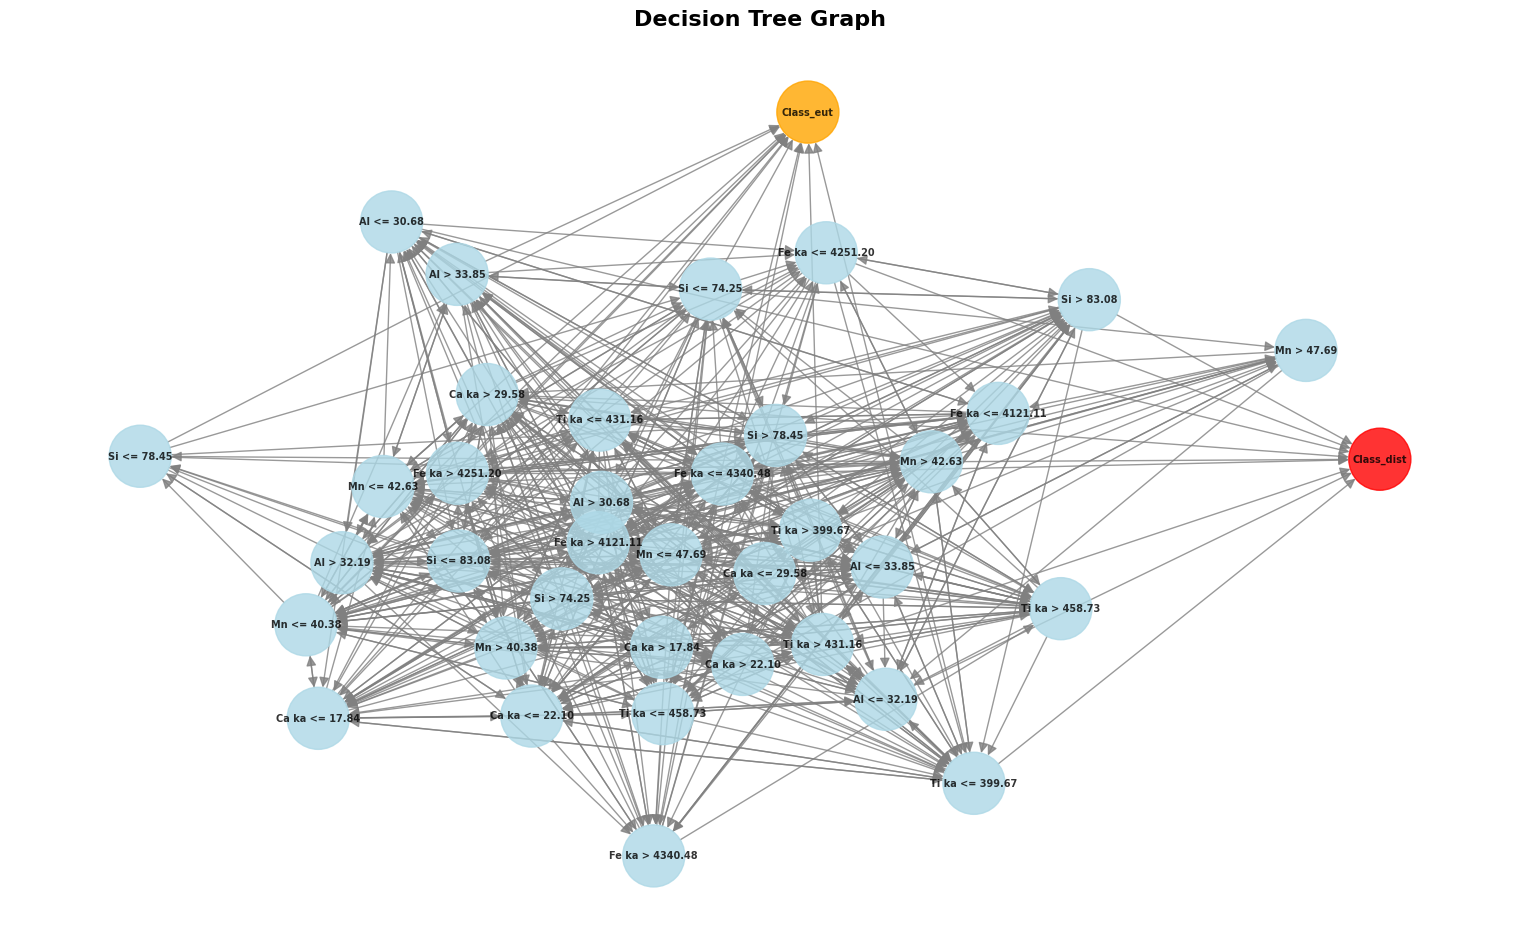

In [219]:
# vamos usar os resultados de cada bag em bags_result para gerar varios caminhos em um grafo com o networkX
# a lista de predicados (chaves) de cada bag será usada para gerar os caminhos do grafo, que será direcionado pela ordem dos predicados cuja informação mútua (MI) é maior
# a MI esta disponível em mi_results_dict, vamos usar ela para ordenar os predicados de cada bag
# ja as arestas do grafo serao ponderadas pela frequencia com que uma amostra satisfaz dois predicados em sequencia (co-ocorrencia)

# Construindo o grafo de decisão a partir dos bags de predicados
import networkx as nx
import pandas as pd
import numpy as np

DG = nx.DiGraph() # criando um grafo direcionado

# Adicionando nós terminais para cada classe
DG.add_node('Class_eut', node_type='terminal', class_label='eut') # nó terminal para classe eutrophic
DG.add_node('Class_dist', node_type='terminal', class_label='dist') # nó terminal para classe dystrophic

for bag_name, bag_predicates_dict in bags_result.items(): # iterando sobre cada bag e seus predicados para construir os caminhos diferentes
    
    # Obtendo o ranking de MI para este bag (predicados ordenados por importância)
    mi_ranking = mi_results_dict[bag_name]
    ordered_predicates = mi_ranking['Predicate'].tolist()
    
    # Filtrando apenas predicados que realmente existem neste bag
    ordered_predicates = [p for p in ordered_predicates if p in bag_predicates_dict.keys()] # a compreensão de lista funciona fazendo p percorrer a lista de predicados ordenados e incluindo apenas os que existem no dicionário do bag atual (pela chave)
    
    # Se o bag estiver vazio, pula para o próximo
    if len(ordered_predicates) == 0:
        continue # pulando bags vazios

    # construindo o caminho no grafo para este bag
    for i in range(len(ordered_predicates) - 1): # iterando sobre os predicados do bag, exceto o último (por isso o -1, que evita o ultimo índice)
        pred_current = ordered_predicates[i]  # predicado atual
        pred_next = ordered_predicates[i + 1]  # próximo predicado
        
        # Adicionando nós (se ainda não existem)
        DG.add_node(pred_current, node_type='predicate') # nó do predicado atual
        DG.add_node(pred_next, node_type='predicate') # nó do próximo predicado
        
        # Peso da aresta = co-ocorrência entre os dois predicados no dataset completo (quantas amostras satisfazem AMBOS os predicados)
        co_occurrence = co_occurrence_matrix_df.loc[pred_current, pred_next] # obtendo a co-ocorrência do DataFrame
        
        if DG.has_edge(pred_current, pred_next): # verificando se a aresta já existe
            # Se aresta já existe, incrementa o peso (múltiplos bags podem usar a mesma transição)
            DG[pred_current][pred_next]['weight'] += co_occurrence # incrementando o peso da aresta existente ( o += adiciona o valor da co-ocorrência ao peso atual)
        else:
            # Cria nova aresta entre predicados consecutivos
            DG.add_edge(pred_current, pred_next, weight=co_occurrence, bag=bag_name) # adicionando a aresta com o peso da co-ocorrência e nomeando a aresta com o nome do bag (ex: Bag_1)
    
    # conectando o último predicado ao nó terminal correspondente à classe majoritária
    last_pred = ordered_predicates[-1]  # último predicado do bag
    DG.add_node(last_pred, node_type='predicate') # adicionando o nó do último predicado (se ainda não existir)
    
    # Pegando o DataFrame do último predicado deste bag
    df_last = bag_predicates_dict[last_pred]
    
    # Contando quantas amostras de cada classe existem no último predicado
    class_counts = df_last['Class_Label'].value_counts() # o value_counts conta quantas vezes cada classe aparece na coluna 'Class_Label'
    
    # Determinando a classe majoritária (a que tem mais amostras)
    majority_class = class_counts.idxmax()
    
    # Nome do nó terminal correspondente à classe majoritária
    terminal_node = f'Class_{majority_class}'
    
    # Peso da aresta = numero de amostras que satisfazem o ultimo predicado neste bag
    n_samples_last = class_counts.count() # número total de amostras que satisfazem o último predicado (soma das contagens de todas as classes)
    
    if DG.has_edge(last_pred, terminal_node): # verificando se a aresta já existe
        # Se aresta já existe, incrementa o peso
        DG[last_pred][terminal_node]['weight'] += n_samples_last
    else:
        # Cria nova aresta último predicado -> terminal
        DG.add_edge(last_pred, terminal_node, weight=n_samples_last, bag=bag_name)


# Resumo do grafo
print(f"\nResumo do Grafo")
print(f"Total de nós: {DG.number_of_nodes()}")
print(f"Total de arestas: {DG.number_of_edges()}")
print(f"Nós de predicados: {len([n for n in DG.nodes() if DG.nodes[n].get('node_type') in ['predicate', 'root_predicate']])}")
print(f"Nós terminais: {len([n for n in DG.nodes() if DG.nodes[n].get('node_type') == 'terminal'])}")

import matplotlib.pyplot as plt
import networkx as nx

# Layout hierárquico simples
pos = nx.spring_layout(DG, k=10, iterations=100, seed=42) # o k controla a distância entre os nós, o iterations controla a precisão do layout

# Cores dos nós
colors = []
for node in DG.nodes():
    node_type = DG.nodes[node].get('node_type', 'predicate')
    if node_type == 'root_predicate':
        colors.append('green')
    elif node_type == 'terminal':
        colors.append('orange' if DG.nodes[node].get('class_label') == 'eut' else 'red')
    else:
        colors.append('lightblue')

# Plotando
plt.figure(figsize=(15, 9))
nx.draw(DG, pos, 
        node_color=colors,
        node_size=2000,
        with_labels=True,
        font_size=7,
        font_weight='bold',
        arrows=True,
        arrowsize=15,
        edge_color='gray',
        alpha=0.8)

plt.title('Decision Tree Graph', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [220]:
# verificando se o grafo tem arestas bidirecionadas
bidirectional_edges = [(u, v) for u, v in DG.edges() if DG.has_edge(v, u)] # percorrendo as arestas e verificando se a aresta inversa existe
print(f"Total de arestas bidirecionais: {len(bidirectional_edges)}")

Total de arestas bidirecionais: 326


In [221]:
# calculando a local reaching centrality de todos os nós do grafo levando em conta os pesos das arestas
local_reaching_centrality = {node: nx.local_reaching_centrality(DG, node, weight='weight') for node in DG.nodes()}
# exibindo todos os valores de local reaching centrality (do maior para o menor)
sorted_lrc = sorted(local_reaching_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nLocal Reaching Centrality dos Nós (do maior para o menor)")
for node, lrc in sorted_lrc:
    print(f"Nó: {node}, LRC: {lrc:.4f}")


Local Reaching Centrality dos Nós (do maior para o menor)
Nó: Ca ka > 17.84, LRC: 6.5885
Nó: Mn > 40.38, LRC: 3.2423
Nó: Si > 74.25, LRC: 3.1812
Nó: Al > 32.19, LRC: 3.1340
Nó: Ca ka <= 29.58, LRC: 2.8953
Nó: Ca ka > 22.10, LRC: 2.7044
Nó: Ti ka > 399.67, LRC: 2.6125
Nó: Al > 30.68, LRC: 2.5348
Nó: Al <= 33.85, LRC: 2.4549
Nó: Ti ka > 431.16, LRC: 2.3672
Nó: Ca ka > 29.58, LRC: 2.3324
Nó: Mn > 42.63, LRC: 2.3289
Nó: Ca ka <= 22.10, LRC: 2.2345
Nó: Fe ka > 4121.11, LRC: 2.1974
Nó: Si > 78.45, LRC: 2.1961
Nó: Ti ka <= 458.73, LRC: 2.1326
Nó: Mn <= 42.63, LRC: 2.1294
Nó: Si <= 83.08, LRC: 2.0828
Nó: Ca ka <= 17.84, LRC: 2.0587
Nó: Ti ka > 458.73, LRC: 2.0385
Nó: Ti ka <= 431.16, LRC: 2.0022
Nó: Al <= 32.19, LRC: 1.8956
Nó: Fe ka <= 4340.48, LRC: 1.8767
Nó: Si <= 74.25, LRC: 1.8600
Nó: Mn <= 40.38, LRC: 1.8578
Nó: Fe ka <= 4121.11, LRC: 1.8421
Nó: Mn <= 47.69, LRC: 1.8113
Nó: Al > 33.85, LRC: 1.7127
Nó: Fe ka > 4340.48, LRC: 1.6801
Nó: Fe ka > 4251.20, LRC: 1.6415
Nó: Al <= 30.68, LRC: 1.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\networkx\algorithms\centrality\reaching.py:193: RuntimeWarning:

divide by zero encountered in scalar divide



In [222]:
# plotando o vip scores para comparação
plsda_results[4].T.plot()

In [223]:
reg_vet.T.plot()

In [226]:
# calculando a centralidade de autovalor (eigenvector centrality) do grafo direcionado considerando os pesos das arestas
eigenvector_centrality = {node: val for node, val in nx.eigenvector_centrality(DG, max_iter=1000, weight='weight').items()}
# exibindo todos os valores de eigenvector centrality (do maior para o menor)
sorted_evc = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nEigenvector Centrality dos Nós (do maior para o menor)")
for node, evc in sorted_evc:
    print(f"Nó: {node}, EVC: {evc:.4f}")


Eigenvector Centrality dos Nós (do maior para o menor)
Nó: Si > 74.25, EVC: 0.3061
Nó: Ti ka > 399.67, EVC: 0.2903
Nó: Mn <= 47.69, EVC: 0.2797
Nó: Mn > 40.38, EVC: 0.2691
Nó: Ca ka <= 29.58, EVC: 0.2631
Nó: Al > 30.68, EVC: 0.2389
Nó: Ca ka > 22.10, EVC: 0.2365
Nó: Fe ka <= 4340.48, EVC: 0.2308
Nó: Al <= 33.85, EVC: 0.2299
Nó: Fe ka > 4121.11, EVC: 0.2237
Nó: Ti ka <= 431.16, EVC: 0.2022
Nó: Ti ka > 431.16, EVC: 0.1973
Nó: Ti ka <= 458.73, EVC: 0.1797
Nó: Ca ka <= 22.10, EVC: 0.1705
Nó: Si > 78.45, EVC: 0.1669
Nó: Al > 32.19, EVC: 0.1580
Nó: Ca ka > 17.84, EVC: 0.1410
Nó: Si <= 83.08, EVC: 0.1248
Nó: Mn > 42.63, EVC: 0.1234
Nó: Mn <= 42.63, EVC: 0.1229
Nó: Fe ka > 4251.20, EVC: 0.1201
Nó: Ti ka > 458.73, EVC: 0.1022
Nó: Al <= 32.19, EVC: 0.0976
Nó: Ca ka <= 17.84, EVC: 0.0874
Nó: Mn <= 40.38, EVC: 0.0791
Nó: Ca ka > 29.58, EVC: 0.0676
Nó: Al > 33.85, EVC: 0.0603
Nó: Ti ka <= 399.67, EVC: 0.0540
Nó: Fe ka <= 4121.11, EVC: 0.0510
Nó: Fe ka > 4340.48, EVC: 0.0501
Nó: Al <= 30.68, EVC: 0

# **Exemplo para entender o netowrkX**

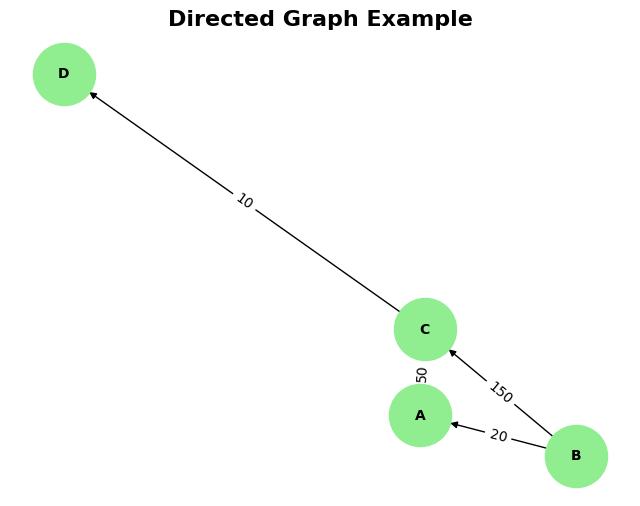

In [57]:
DG = nx.DiGraph()
DG.add_node("A")
DG.add_node("B")
DG.add_node("C")
DG.add_node("D")
DG.add_edge("B", "A", weight=20)
DG.add_edge("B", "C", weight=150)
DG.add_edge("A", "C", weight=50)
DG.add_edge("C", "D", weight=10)
 #plotar o grafo direcionado
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
pos = nx.spring_layout(DG, seed=42)
nx.draw(DG, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(DG, 'weight')
nx.draw_networkx_edge_labels(DG, pos, edge_labels=edge_labels)
plt.title('Directed Graph Example', fontsize=16, fontweight='bold')
plt.show()

In [58]:
# calculando a local reach centrality para os nós do grafo direcionado DG levando em conta o peso das arestas
local_reach_centrality_weighted = {node: nx.local_reaching_centrality(DG, node, weight='weight') for node in DG.nodes()}
pd.Series(local_reach_centrality_weighted).sort_values(ascending=False)

B    1.449275
A    0.463768
C    0.057971
D    0.000000
dtype: float64